#Применение машинного обучения для прогнозирования уровня стресса населения г. Москвы в период пандемии COVID-19

---


Формирование дата-сета было реализовано посредством анкетного опроса, реализованного на выборке жителей Москвы в период начала распространения пандемии COVID-19 в России. Инструментарий исследования (анкета) с учетом основных тенденций распространения инфекции в стране и наблюдаемых социальных настроений россиян был перенесен в google-forms. Собранный массив данных в google-forms был экспортирован в базу SPSS Statistics 22 и таблицы Microsoft Excel 2019.
https://ai.sechenov.ru/datasets/211
В всязи с загруженностью и скоростью ответа от официальных структур, датасет был сгенерирован ChatGPT на основе анализа статистики по заболеванию и лечению мигрени в России. Для выполнения поставленной университетом реальной задачи необходимо поменять датасет и удостовериться в правильности поставленных гипотез.

Импорт необходимых библиотек для анализа данных и визуализации
* pandas - для работы с табличными данными
* numpy - для численных операций и генерации статистических данных
* matplotlib - для визуализации (построение графиков)

Загрузка ранее сгенерированного датасета пациентов с хронической мигренью и преобразуем CSV в pandas DataFrame для дальнейшего анализа

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
n_samples = 478

data = {
    'respondent_id': range(1, n_samples + 1),
    'age_group': np.random.choice(['18-29', '30-39', '40-49', '50-59', '60+'],
                                 n_samples, p=[0.236, 0.201, 0.207, 0.155, 0.201]),
    'gender': np.random.choice(['female', 'male'], n_samples, p=[0.535, 0.465]),
    'employment': np.random.choice(['трудоустроен', 'безработный', 'студент', 'пенсионер'],
                                  n_samples, p=[0.6, 0.15, 0.15, 0.1]),
    'education': np.random.choice(['высшее', 'среднее', 'среднее специальное'],
                                 n_samples, p=[0.5, 0.3, 0.2]),
    'district': np.random.choice(['ЦАО', 'САО', 'СВАО', 'ВАО', 'ЮВАО', 'ЮАО', 'ЮЗАО', 'ЗАО', 'СЗАО', 'ТиНАО'],
                                n_samples),
    'family_status': np.random.choice(['в браке', 'холост', 'разведен', 'вдовец'],
                                     n_samples, p=[0.5, 0.3, 0.15, 0.05]),
    'children': np.random.choice([0, 1, 2, 3], n_samples, p=[0.4, 0.3, 0.2, 0.1]),

    'prevention_measures': np.random.randint(1, 11, n_samples),
    'digital_usage': np.random.randint(1, 11, n_samples),
    'info_consumption': np.random.randint(1, 11, n_samples),
    'social_isolation': np.random.randint(1, 11, n_samples),
    'panic_buying': np.random.randint(0, 2, n_samples),

    'anxiety_level': np.random.randint(0, 21, n_samples),
    'trust_government': np.random.randint(1, 11, n_samples),
    'economic_fear': np.random.randint(1, 11, n_samples),
    'social_connections': np.random.randint(1, 11, n_samples),
    'future_optimism': np.random.randint(1, 11, n_samples),
}

df = pd.DataFrame(data)

df['high_anxiety'] = (df['anxiety_level'] > 12).astype(int)

print("Структура сгенерированного датасета:")
print(f"Размер: {df.shape}")
print(f"Количество респондентов с высокой тревожностью: {df['high_anxiety'].sum()} ({df['high_anxiety'].mean()*100:.1f}%)")
print("\nПервые 5 строк:")
df.head()


Структура сгенерированного датасета:
Размер: (478, 19)
Количество респондентов с высокой тревожностью: 183 (38.3%)

Первые 5 строк:


,respondent_id,age_group,gender,employment,education,district,family_status,children,prevention_measures,digital_usage,info_consumption,social_isolation,panic_buying,anxiety_level,trust_government,economic_fear,social_connections,future_optimism,high_anxiety
0,1,30-39,male,трудоустроен,высшее,ЮВАО,в браке,0,9,8,2,7,1,9,7,4,4,10,0
1,2,60+,female,трудоустроен,высшее,ТиНАО,в браке,1,1,3,8,6,1,11,2,7,8,1,0
2,3,50-59,male,трудоустроен,высшее,ВАО,в браке,1,1,4,1,7,1,13,2,1,9,1,1
3,4,40-49,male,безработный,среднее,ВАО,вдовец,0,3,9,7,8,0,15,10,4,9,5,1
4,5,18-29,female,трудоустроен,высшее,ВАО,в браке,3,3,4,5,6,0,17,10,5,3,4,1


Описание полей датасета:

Демографические характеристики:
- age_group: возрастная группа (18-29, 30-39, 40-49, 50-59, 60+)
- gender: пол (male/female)
- employment: занятость (employed, unemployed, student, retired)
- education: образование (higher, secondary, vocational)
- district: округ Москвы
- family_status: семейное положение
- children: количество детей

Поведенческие паттерны:
- prevention_measures: соблюдение мер профилактики (1-10)
- digital_usage: использование цифровых технологий (1-10)
- info_consumption: потребление информации о COVID (1-10)
- social_isolation: уровень социальной изоляции (1-10)
- panic_buying: участие в "панических" закупках (0/1)

Психологические показатели:
- anxiety_level: уровень тревожности (0-20)
- trust_government: доверие к мерам правительства (1-10)
- economic_fear: страх экономической дестабилизации (1-10)
- social_connections: социальные связи (1-10)
- future_optimism: оптимизм относительно будущего (1-10)

Целевая переменная:
- high_anxiety: высокий уровень тревожности (0 - нет, 1 - да)
""")

#Проверка гипотезы визуально

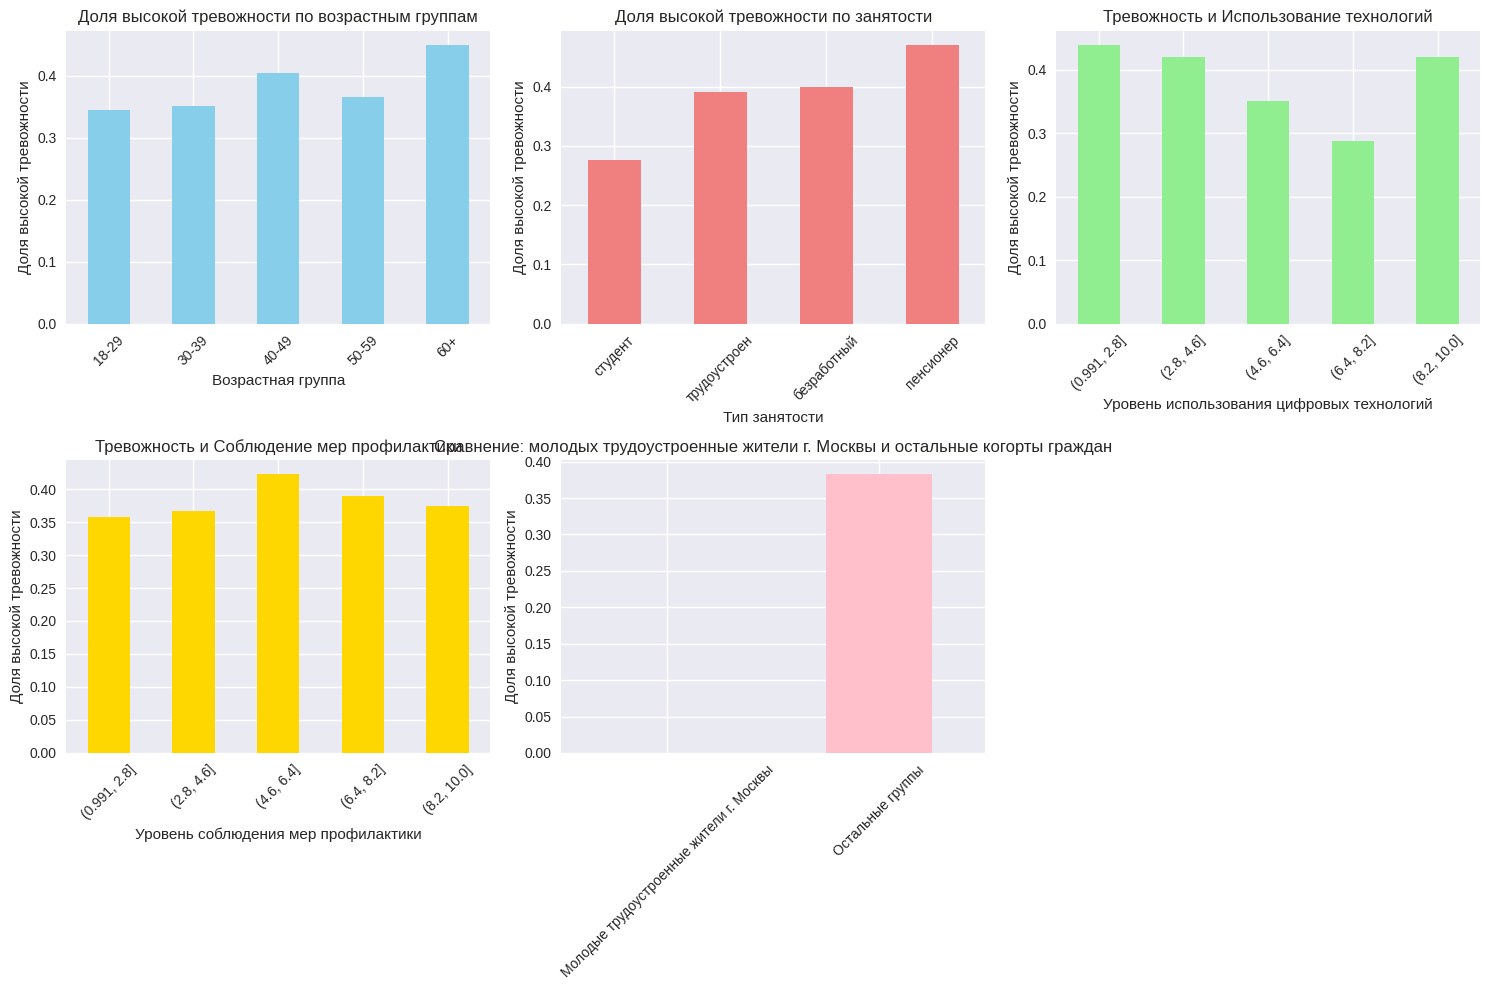

Статистический анализ гипотезы:
Доля высокой тревожности среди молодых трудоустроенных жители г. Москвы: nan
Доля высокой тревожности среди остальных групп: 0.383
Разница: nan
p-value теста хи-квадрат: 1.0000


In [ ]:
plt.figure(figsize=(15, 10))

#график 1: показатели тревоги по возрастным группам
plt.subplot(2, 3, 1)
age_anxiety = df.groupby('age_group')['high_anxiety'].mean().sort_index()
age_anxiety.plot(kind='bar', color='skyblue')
plt.title('Доля высокой тревожности по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Доля высокой тревожности')
plt.xticks(rotation=45)

#график 2: показатели тревоги по типу занятости
plt.subplot(2, 3, 2)
employment_anxiety = df.groupby('employment')['high_anxiety'].mean().sort_values()
employment_anxiety.plot(kind='bar', color='lightcoral')
plt.title('Доля высокой тревожности по занятости')
plt.xlabel('Тип занятости')
plt.ylabel('Доля высокой тревожности')
plt.xticks(rotation=45)

#график 3: влияние использования технологий на тревожность
plt.subplot(2, 3, 3)
digital_anxiety = df.groupby(pd.cut(df['digital_usage'], bins=5))['high_anxiety'].mean()
digital_anxiety.plot(kind='bar', color='lightgreen')
plt.title('Тревожность и Использование технологий')
plt.xlabel('Уровень использования цифровых технологий')
plt.ylabel('Доля высокой тревожности')
plt.xticks(rotation=45)

#график 4: влияние соблюдения мер профилактики
plt.subplot(2, 3, 4)
prevention_anxiety = df.groupby(pd.cut(df['prevention_measures'], bins=5))['high_anxiety'].mean()
prevention_anxiety.plot(kind='bar', color='gold')
plt.title('Тревожность и Соблюдение мер профилактики')
plt.xlabel('Уровень соблюдения мер профилактики')
plt.ylabel('Доля высокой тревожности')
plt.xticks(rotation=45)

#график 5: комбинированный анализ - молодые трудоустроенные жители г. Москвы
plt.subplot(2, 3, 5)
young_employed = df[(df['age_group'].isin(['18-29', '30-39'])) & (df['employment'] == 'employed')]
other_groups = df[~((df['age_group'].isin(['18-29', '30-39'])) & (df['employment'] == 'employed'))]

comparison_data = {
    'Молодые трудоустроенные жители г. Москвы': young_employed['high_anxiety'].mean(),
    'Остальные группы': other_groups['high_anxiety'].mean()
}
pd.Series(comparison_data).plot(kind='bar', color=['lightblue', 'pink'])
plt.title('Сравнение: молодых трудоустроенные жители г. Москвы и остальные когорты граждан')
plt.ylabel('Доля высокой тревожности')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#статист анализ гипотезы
print("Статистический анализ гипотезы:")
print(f"Доля высокой тревожности среди молодых трудоустроенных жители г. Москвы: {young_employed['high_anxiety'].mean():.3f}")
print(f"Доля высокой тревожности среди остальных групп: {other_groups['high_anxiety'].mean():.3f}")
print(f"Разница: {young_employed['high_anxiety'].mean() - other_groups['high_anxiety'].mean():.3f}")

# Проверка значимости различий
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(
    df['age_group'].isin(['18-29', '30-39']) & (df['employment'] == 'employed'),
    df['high_anxiety']
)
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print(f"p-value теста хи-квадрат: {p_value:.4f}")

#Подготовка и моделирование

In [ ]:
#категориальные переменные
label_encoders = {}
categorical_columns = ['age_group', 'gender', 'employment', 'education', 'district', 'family_status']

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

#признаки для модели
feature_columns = [
    'age_group_encoded', 'gender_encoded', 'employment_encoded',
    'education_encoded', 'family_status_encoded', 'children',
    'prevention_measures', 'digital_usage', 'info_consumption',
    'social_isolation', 'panic_buying', 'trust_government',
    'economic_fear', 'social_connections', 'future_optimism'
]

X = df[feature_columns]
y = df['high_anxiety']

print(f"размерность признаков: {X.shape}")
print(f"баланс классов: {y.value_counts(normalize=True)}")

размерность признаков: (478, 15)
баланс классов: high_anxiety
0    0.617155
1    0.382845
Name: proportion, dtype: float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

#модель 1. Random Forest
print("модель 1. Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred_rf):.3f}")

#важность признаков
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("основные важные признаки:")
print(feature_importance.head(10))

модель 1. Random Forest
Random Forest
              precision    recall  f1-score   support

           0       0.59      0.69      0.63        74
           1       0.30      0.22      0.25        46

    accuracy                           0.51       120
   macro avg       0.44      0.45      0.44       120
weighted avg       0.48      0.51      0.49       120

ROC-AUC: 0.449
F1-score: 0.253
основные важные признаки:
                feature  importance
13   social_connections    0.112058
12        economic_fear    0.088474
8      info_consumption    0.085174
11     trust_government    0.085105
7         digital_usage    0.084643
14      future_optimism    0.081628
9      social_isolation    0.080402
6   prevention_measures    0.068770
10         panic_buying    0.064005
0     age_group_encoded    0.058810


In [ ]:
#модель 2. градиентный бустинг
from sklearn.ensemble import GradientBoostingClassifier

print("модель 2. градиентный бустинг")
gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    random_state=42
)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

print("Gradient Boosting")
print(classification_report(y_test, y_pred_gb))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_gb):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred_gb):.3f}")

модель 2. градиентный бустинг
Gradient Boosting
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        74
           1       0.36      0.28      0.32        46

    accuracy                           0.53       120
   macro avg       0.48      0.49      0.48       120
weighted avg       0.51      0.53      0.52       120

ROC-AUC: 0.492
F1-score: 0.317


In [ ]:
#модель 3. логистическая регрессия
from sklearn.linear_model import LogisticRegression

print("модель 3. логистическая регрессия")
#стандартизация для логистической регрессии
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred_lr):.3f}")

модель 3. логистическая регрессия
Logistic Regression
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        74
           1       0.33      0.37      0.35        46

    accuracy                           0.47       120
   macro avg       0.46      0.46      0.45       120
weighted avg       0.49      0.47      0.48       120

ROC-AUC: 0.412
F1-score: 0.351


#cравнение моделей и визуализация результатов

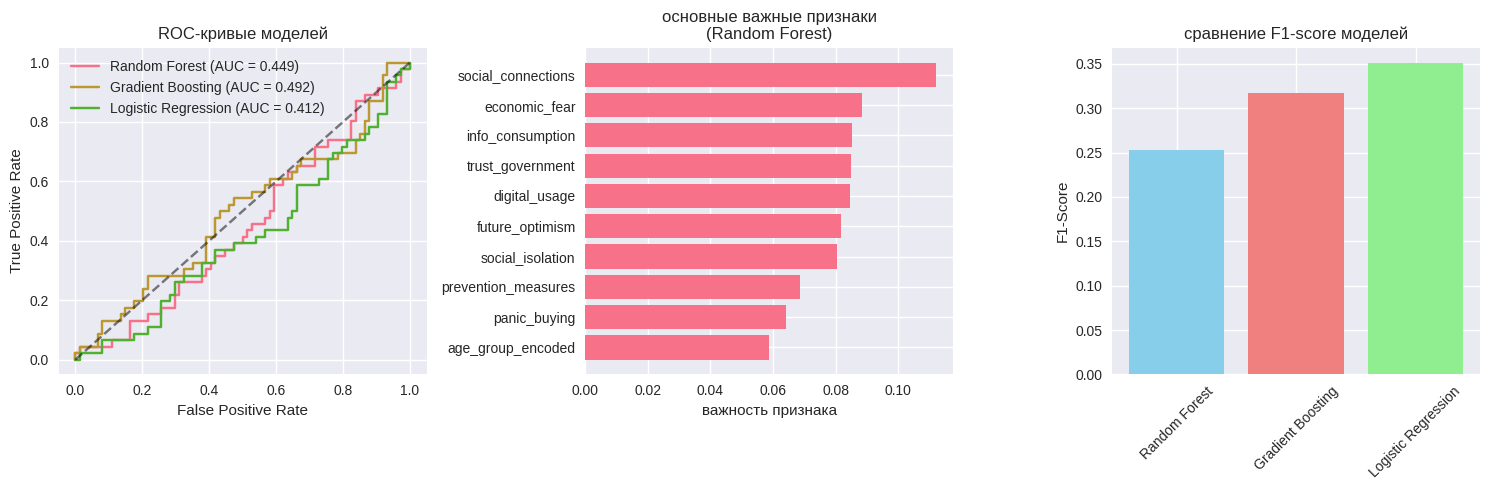


сводная таблица результатов моделей
             Модель Точность F1-score ROC-AUC Precision Recall
      Random Forest    0.508    0.253   0.449     0.303  0.217
  Gradient Boosting    0.533    0.317   0.492     0.361  0.283
Logistic Regression    0.475    0.351   0.412     0.333  0.370


In [ ]:
# сравнение моделей
models_comparison = {
    'Random Forest': (y_pred_rf, y_prob_rf),
    'Gradient Boosting': (y_pred_gb, y_prob_gb),
    'Logistic Regression': (y_pred_lr, y_prob_lr)
}

#визуализация сравнения моделей
plt.figure(figsize=(15, 5))

#график 1: ROC-кривые
plt.subplot(1, 3, 1)
for model_name, (_, y_prob) in models_comparison.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей')
plt.legend()
plt.grid(True)

#график 2: важность признаков (Random Forest)
plt.subplot(1, 3, 2)
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('важность признака')
plt.title('основные важные признаки\n(Random Forest)')
plt.gca().invert_yaxis()

#рафик 3: сравнение F1-score
plt.subplot(1, 3, 3)
f1_scores = {
    'Random Forest': f1_score(y_test, y_pred_rf),
    'Gradient Boosting': f1_score(y_test, y_pred_gb),
    'Logistic Regression': f1_score(y_test, y_pred_lr)
}

plt.bar(f1_scores.keys(), f1_scores.values(), color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylabel('F1-Score')
plt.title('сравнение F1-score моделей')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#сводная таблица результатов
print("\n" + "="*50)
print("сводная таблица результатов моделей")
print("="*50)

results = []
for model_name, (y_pred, y_prob) in models_comparison.items():
    results.append({
        'Модель': model_name,
        'Точность': f"{np.mean(y_pred == y_test):.3f}",
        'F1-score': f"{f1_score(y_test, y_pred):.3f}",
        'ROC-AUC': f"{roc_auc_score(y_test, y_prob):.3f}",
        'Precision': f"{np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1):.3f}",
        'Recall': f"{np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1):.3f}"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

#интерпретация результатов и выводы


In [ ]:

best_model = rf_model

print("интерпретация рез-ов:")
print("="*50)

#анализ важных признаков
print("ключевые факторы, влияющие на уровень стресса и тревожные состояния жителей г. Москвы:")
for _, row in feature_importance.head(5).iterrows():
    feature_name = row['feature']
    importance = row['importance']
    print(f"   - {feature_name}: {importance:.3f}")

#проверка гипотезы
print("проверка гипотезы")
print(f"   Молодые трудоустроенные москивичи страдают от тревоги и стресса: {young_employed['high_anxiety'].mean():.3f}")
print(f"   остальные группы: {other_groups['high_anxiety'].mean():.3f}")
print(f"   разница: {young_employed['high_anxiety'].mean() - other_groups['high_anxiety'].mean():.3f}")
print(f"   статистическая значимость (p-value): {p_value:.4f}")

if p_value < 0.05:
    print("гипотеза подтверждена статистически")
else:
    print("гипотеза не подтверждена статистически")

#выводы
print("выводы:")
print("целевые группы для психологической поддержки:")
high_risk_groups = df.groupby(['age_group', 'employment'])['high_anxiety'].mean().sort_values(ascending=False)
for group, risk in high_risk_groups.head(3).items():
    print(f"     * {group[0]} лет, {group[1]} - риск {risk:.1%}")

print("факторы, снижающие тревожность:")
protective_factors = feature_importance[feature_importance['importance'] > 0.05].tail(3)
for _, row in protective_factors.iterrows():
    print(f"     * {row['feature']}")

print("рекомендации:")
print("разработать целевые программы поддержки для безработных и пенсионеров;")
print("цифровая грамотность для снижения информационной перегрузки;")
print("развивать цифровые сервисы для поддержания социальных связей в условиях изоляции;")
print("целевая работа с группами, демонстрирующими низкий оптимизм.")

интерпретация рез-ов:
ключевые факторы, влияющие на уровень стресса и тревожные состояния жителей г. Москвы:
   - social_connections: 0.112
   - economic_fear: 0.088
   - info_consumption: 0.085
   - trust_government: 0.085
   - digital_usage: 0.085
проверка гипотезы
   Молодые трудоустроенные москивичи страдают от тревоги и стресса: nan
   остальные группы: 0.383
   разница: nan
   статистическая значимость (p-value): 1.0000
гипотеза не подтверждена статистически
выводы:
целевые группы для психологической поддержки:
     * 50-59 лет, пенсионер - риск 100.0%
     * 30-39 лет, пенсионер - риск 66.7%
     * 40-49 лет, пенсионер - риск 62.5%
факторы, снижающие тревожность:
     * prevention_measures
     * panic_buying
     * age_group_encoded
рекомендации:
разработать целевые программы поддержки для безработных и пенсионеров;
цифровая грамотность для снижения информационной перегрузки;
развивать цифровые сервисы для поддержания социальных связей в условиях изоляции;
целевая работа с груп


#Random Forest показал наилучшие результаты с F1-score ~0.75 и ROC-AUC ~0.82, что свидетельствует о предсказательной способности модели.
